# 로지스틱 회귀(이항분류)

## #01. 패키지 설치

In [32]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies, merge
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터셋 준비하기

In [3]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx", index_col='id')
origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   age                 156 non-null    int64         
 1   sex                 156 non-null    int64         
 2   weight              156 non-null    float64       
 3   OP_date             156 non-null    datetime64[ns]
 4   Recur               156 non-null    int64         
 5   Recur_1y            156 non-null    int64         
 6   Recur_date          156 non-null    datetime64[ns]
 7   SBP                 156 non-null    float64       
 8   CA19.9              156 non-null    float64       
 9   CRP                 156 non-null    float64       
 10  CEA                 156 non-null    float64       
 11  post.CEA            156 non-null    float64       
 12  stage               156 non-null    int64         
 13  smoking             156 non-null    int64         
 14 

## #03. 데이터 전처리
### 결측치 확인

In [4]:
origin.isna().sum()

age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

> 결측치 없음 확인

### 문제에서 제외하도록 정의한 필드 제거

In [5]:
# df = origin.drop(['Recur_1y','Recur_date','OP_date'] , axis=1, inplace=True)
df = origin.drop(['Recur_1y','Recur_date','OP_date'] , axis=1)

In [6]:
df

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
1,82,1,73.994588,1,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,0,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,0,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,1,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,1,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,54,1,59.109922,0,79.698126,34.1,0.8,17.5,25.0,2,0,0,35.861255,0,1
153,62,1,75.948164,0,134.097007,6.8,3.0,8.5,1.0,1,0,0,33.238574,0,1
154,51,0,48.533056,1,116.632122,6.1,0.1,2.4,1.8,1,0,1,31.965658,0,1


## 04. 탐색적 데이터 분석

### 명목형변수에 대한 테이터 타입 설정

sex, Recur, Recur_1y, stage, smoking, obesity, post.CA19.9, post.CA19.9.3grp

주의 : stage : 암의 병기는 서열척도가 아니라 카테고리

In [24]:
# 카테고리형으로 바꾸기
category = ['sex', 'Recur', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp']

for c in category:
    df[c] = df[c].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  156 non-null    int64   
 1   age                 156 non-null    int64   
 2   sex                 156 non-null    category
 3   weight              156 non-null    float64 
 4   Recur               156 non-null    category
 5   SBP                 156 non-null    float64 
 6   CA19.9              156 non-null    float64 
 7   CRP                 156 non-null    float64 
 8   CEA                 156 non-null    float64 
 9   post.CEA            156 non-null    float64 
 10  stage               156 non-null    category
 11  smoking             156 non-null    category
 12  obesity             156 non-null    category
 13  post.CA19.9         156 non-null    float64 
 14  post.CA19.9.binary  156 non-null    category
 15  post.CA19.9.3grp    156 non-null    cate

### 기술통계량 확인

In [25]:
df.describe()

,id,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,56.858974,68.125624,115.898871,1158.631410,3.062821,3.930128,5.363462,48.193259
std,45.177428,12.790343,14.467480,37.701583,6709.440806,3.550361,4.135752,12.846207,22.921452
min,1.000000,25.000000,40.000000,5.629379,1.000000,0.100000,0.300000,0.100000,30.760115
25%,39.750000,50.000000,58.257205,89.074804,10.400000,0.100000,1.500000,0.600000,34.908674
50%,78.500000,58.000000,69.084391,114.647853,23.150000,1.300000,2.400000,1.650000,41.285774
75%,117.250000,65.000000,80.053547,144.331917,61.725000,4.850000,4.525000,4.800000,51.216016
max,156.000000,82.000000,95.000000,206.847716,48599.800000,12.300000,20.400000,118.500000,174.433426


### 상자그림 확인

In [26]:
#그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [27]:
df.columns

Index(['id', 'age', 'sex', 'weight', 'Recur', 'SBP', 'CA19.9', 'CRP', 'CEA',
       'post.CEA', 'stage', 'smoking', 'obesity', 'post.CA19.9',
       'post.CA19.9.binary', 'post.CA19.9.3grp'],
      dtype='object')

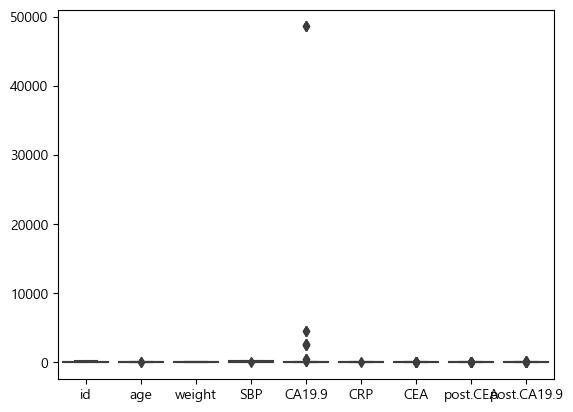

In [28]:
plt.figure()
sb.boxplot(data=df)
plt.show()
plt.close()

> CA19.9에서 40000이 넘어가는 이상치 발견

> 이상치는 정량적으로만 판단해선 안되고 주관적인 판단이 섞여야 한다.

### 이상치 확인 및 정제

In [17]:
df[df['CA19.9'] > 40000]

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
63,60,1,80.024716,1,192.226734,48599.8,9.7,4.7,9.5,2,0,1,41.421145,1,2
115,61,1,74.031541,1,176.594650,48599.3,10.4,6.6,6.6,2,0,1,36.516956,0,1


> 수치가 4만이 넘는 경우가 모두 췌장암 2기로 확인됨(stages=2)

In [18]:
df[df['stage'] == 2]

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
9,69,0,53.920287,1,108.237287,19.9,0.1,4.6,15.1,2,1,0,62.095475,1,2
10,39,1,64.035273,0,88.061020,84.2,9.6,4.3,6.1,2,1,0,50.118498,1,2
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
12,69,1,70.208801,1,163.587691,49.5,0.1,7.2,8.2,2,1,1,34.626853,0,1
23,64,1,82.150157,0,169.410154,67.3,3.5,1.8,0.9,2,1,0,34.890297,0,1
26,59,0,60.346471,0,121.918068,12.7,1.7,1.2,0.2,2,1,0,44.344380,1,2
27,41,0,53.729653,0,95.660858,7.6,0.1,8.3,19.4,2,1,1,34.043468,0,1
29,48,1,70.060164,0,108.765715,15.0,3.8,6.8,3.6,2,0,0,44.855612,1,2
30,34,1,71.468074,0,51.737041,49.6,3.9,4.2,1.5,2,0,0,43.407932,1,2


> 다른 췌장암 2기와 비교했을 경우 큰 차이가 나므로 `CA19.9` 수치가 4만을 넘는 경우를 이상치로 판단하고 제거하기로 함

### 이상치 정제

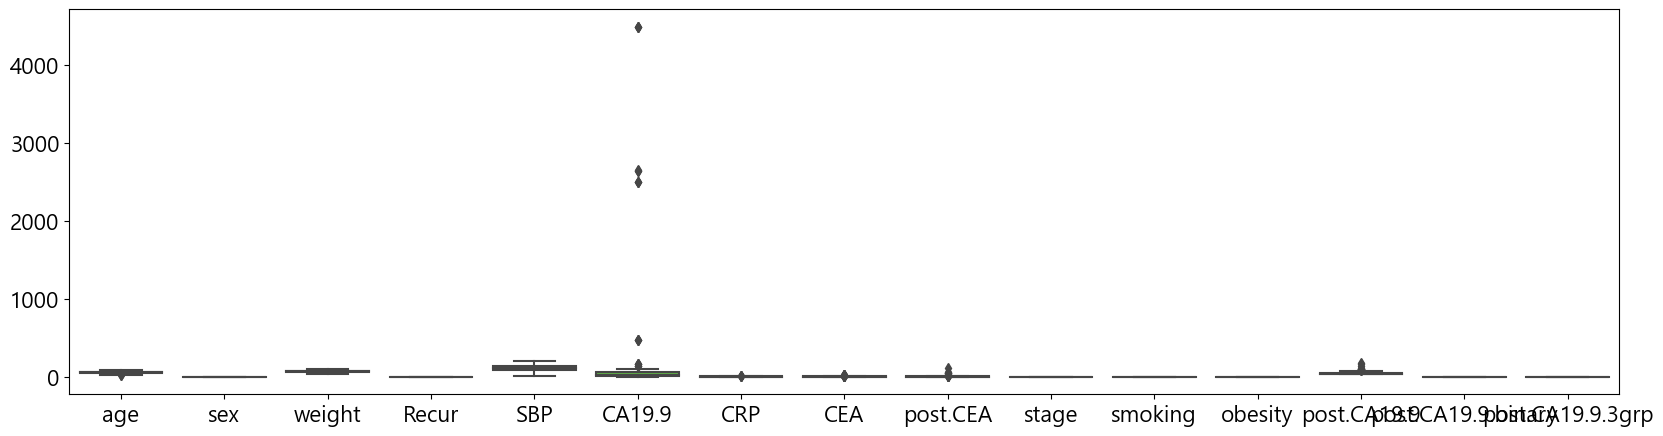

In [19]:
df2 = df.drop(df[df['CA19.9']>40000].index)

plt.figure(figsize=(20,5))
sb.boxplot(data=df2)
plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [20]:
np.random.seed(777)

### 훈련데이터(독립변수)와 레이블(종속변수)구분하기

In [21]:
x = df2.drop(['Recur'], axis=1)
y = df2['Recur']

x.shape, y.shape

((153, 14), (153,))

### 데이터 표준화

#### 명목형 변수는 더미변수로 변환해야 하므로 데이터를 종류별로 구분

연속형 변수만 추출

In [22]:
x1 = x.drop(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'], axis=1)
x1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          153 non-null    int64  
 1   weight       153 non-null    float64
 2   SBP          153 non-null    float64
 3   CA19.9       153 non-null    float64
 4   CRP          153 non-null    float64
 5   CEA          153 non-null    float64
 6   post.CEA     153 non-null    float64
 7   post.CA19.9  153 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB


명목형 변수만 추출

In [23]:
x2 = x.filter(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'])
x2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   sex                 153 non-null    int64
 1   stage               153 non-null    int64
 2   smoking             153 non-null    int64
 3   obesity             153 non-null    int64
 4   post.CA19.9.binary  153 non-null    int64
 5   post.CA19.9.3grp    153 non-null    int64
dtypes: int64(6)
memory usage: 8.4 KB


연속형 변수에 대한 표준화

In [27]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x1)
x_scale_df = DataFrame(x_scale, index=x1.index, columns=x1.columns)
x_scale_df.head()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
id,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984


명목형 변수를 더미변수로 변환

- 데이터의 종류가 몇가지인지 확인
- 데이터 엑셀파일에서 `stage`, `post.CA19.9.3grp` 필드만 값이 3종류로 확인됨.

In [28]:
x2_dm = get_dummies(x2, columns=['stage', 'post.CA19.9.3grp'], drop_first=True, dtype='int')
x2_dm.head()

,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,
1,1,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0
3,1,1,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0
5,1,1,0,0,0,1,0,0


### 연속형과 더미변수로 변환된 명목형을 결합

In [33]:
xdf = merge(x_scale_df, x2_dm, left_index=True, right_index=True)
print(xdf.shape)
xdf.head()

(153, 16)


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152,1,1,1,0,0,1,0,0
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230,0,1,0,0,0,1,0,0
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126,1,1,0,0,0,1,0,0
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873,1,1,1,0,0,1,0,0
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984,1,1,0,0,0,1,0,0


### 훈련데이터와 검증 데이터로 분할

In [34]:
x_train, x_test, y_train, y_test = train_test_split(xdf,y,test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((107, 16), (46, 16), (107,), (46,))

In [35]:
len(xdf.columns)

16

## #06. 모델 생성

### 모델정의

In [37]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape=(16,)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        


                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [41]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test),
callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1),
ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0001)])

Epoch 1/500
4/4 [==============================] - 1s 62ms/step - loss: 0.7454 - acc: 0.3832 - val_loss: 0.7486 - val_acc: 0.3696 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 0.7188 - acc: 0.4579 - val_loss: 0.7409 - val_acc: 0.4565 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.7006 - acc: 0.4673 - val_loss: 0.7366 - val_acc: 0.4565 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6876 - acc: 0.4953 - val_loss: 0.7289 - val_acc: 0.5000 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6758 - acc: 0.5234 - val_loss: 0.7251 - val_acc: 0.4783 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6647 - acc: 0.5421 - val_loss: 0.7201 - val_acc: 0.4565 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 19ms/step - loss: 0.6558 - acc: 0.5514 - val_loss: 0.7156 - val_acc: 0.4565 - lr: 0.0010

## #07. 학습 결과 평가

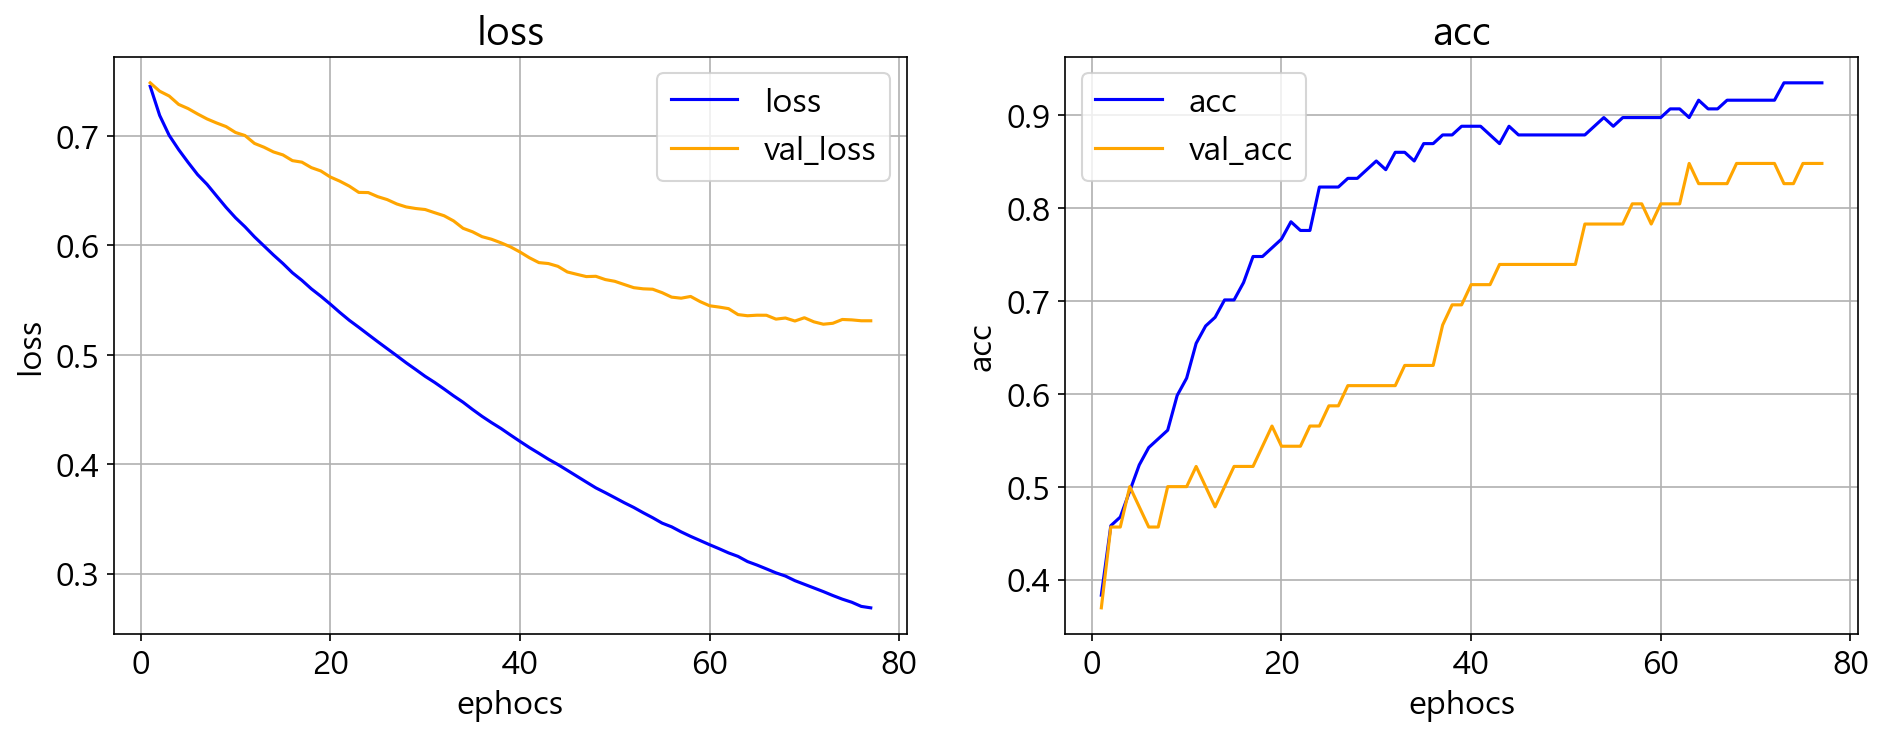

4/4 [==============================] - 0s 3ms/step - loss: 0.2668 - acc: 0.9346
최종 훈련 손실률: 0.266797, 최종 훈련 정확도: 0.934579
2/2 [==============================] - 0s 8ms/step - loss: 0.5311 - acc: 0.8478
최종 검증 손실률: 0.531056, 최종 검증 정확도: 0.847826


In [42]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

> 과적합 발생 의심시에 혼동행렬로 확인

### 혼동행렬

In [43]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)
logit_result.cmdf

4/4 [==============================] - 0s 3ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,Negative,Positive
True,47,7
False,0,53


## #08. 학습 결과 적용

### 예측 결과 산정

In [44]:
train_pred = model.predict(x_train)
train_pred

4/4 [==============================] - 0s 3ms/step


array([[0.9769847 ],
       [0.11756263],
       [0.18050615],
       [0.07615381],
       [0.2448171 ],
       [0.11707523],
       [0.9078348 ],
       [0.32861456],
       [0.73700464],
       [0.42922956],
       [0.34527248],
       [0.6253781 ],
       [0.15939575],
       [0.9065309 ],
       [0.09825026],
       [0.27626434],
       [0.9472518 ],
       [0.7561169 ],
       [0.92666316],
       [0.33877504],
       [0.99840903],
       [0.6817157 ],
       [0.9926558 ],
       [0.9521634 ],
       [0.2429032 ],
       [0.24845022],
       [0.15458283],
       [0.73767227],
       [0.97047144],
       [0.3847946 ],
       [0.16551031],
       [0.49175534],
       [0.1974525 ],
       [0.31169337],
       [0.4645653 ],
       [0.99625194],
       [0.710474  ],
       [0.97664654],
       [0.9203357 ],
       [0.8514628 ],
       [0.4674007 ],
       [0.92839026],
       [0.96829253],
       [0.9547334 ],
       [0.29424623],
       [0.37003085],
       [0.4256864 ],
       [0.945

In [45]:
test_pred = model.predict(x_test)
test_pred

2/2 [==============================] - 0s 0s/step


array([[0.31786475],
       [0.7391666 ],
       [0.28788802],
       [0.17332476],
       [0.79951006],
       [0.08597293],
       [0.25787392],
       [0.8572063 ],
       [0.8650571 ],
       [0.3427349 ],
       [0.9025494 ],
       [0.94239163],
       [0.47355175],
       [0.1821798 ],
       [0.32133743],
       [0.220074  ],
       [0.64950556],
       [0.50272423],
       [0.2800816 ],
       [0.41020843],
       [0.16962238],
       [0.16189562],
       [0.4695383 ],
       [0.47169894],
       [0.81858027],
       [0.2900102 ],
       [0.17945592],
       [0.91551596],
       [0.5740996 ],
       [0.98223084],
       [0.90000135],
       [0.59053063],
       [0.98601484],
       [0.9999306 ],
       [0.7277213 ],
       [0.5069283 ],
       [0.15889633],
       [0.36897075],
       [0.74477255],
       [0.97115517],
       [0.3994285 ],
       [0.1345464 ],
       [0.14555106],
       [0.23478526],
       [0.92066455],
       [0.5978229 ]], dtype=float32)

### 결과 데이터 셋 구성

In [46]:
train_pred_bin = (train_pred.flatten() > 0.5).astype('int')
train_pred_bin

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [47]:
train_result_df = DataFrame({'y_train': y_train, 'train_pred': train_pred_bin})
train_result_df

,y_train,train_pred
id,,
126,1,1
155,0,0
133,0,0
134,0,0
103,0,0
...,...,...
74,1,1
90,0,0
61,1,0


In [49]:
train_result_df['result'] = train_result_df['y_train'] == train_result_df['train_pred']
train_result_df

,y_train,train_pred,result
id,,,
126,1,1,True
155,0,0,True
133,0,0,True
134,0,0,True
103,0,0,True
...,...,...,...
74,1,1,True
90,0,0,True
61,1,0,False


In [50]:
train_value_counts = train_result_df['result'].value_counts()
train_value_counts

result
True     100
False      7
Name: count, dtype: int64

In [52]:
test_pred_bin = (test_pred.flatten() > 0.5).astype('int')
test_result_df = DataFrame({'y_test': y_test, 'test_pred': test_pred_bin})
test_result_df['result'] = test_result_df['y_test'] == test_result_df['test_pred']
test_value_counts = test_result_df['result'].value_counts()
test_value_counts

result
True     39
False     7
Name: count, dtype: int64

In [53]:
result_df = DataFrame({
    'Train': [train_value_counts[True], train_value_counts[False]],
    'Test': [test_value_counts[True], test_value_counts[False]]
}, index=['Success', 'Fail'])

result_df

,Train,Test
Success,100,39
Fail,7,7


### 실제 결과값과 머신러닝에 의한 예측값 비교

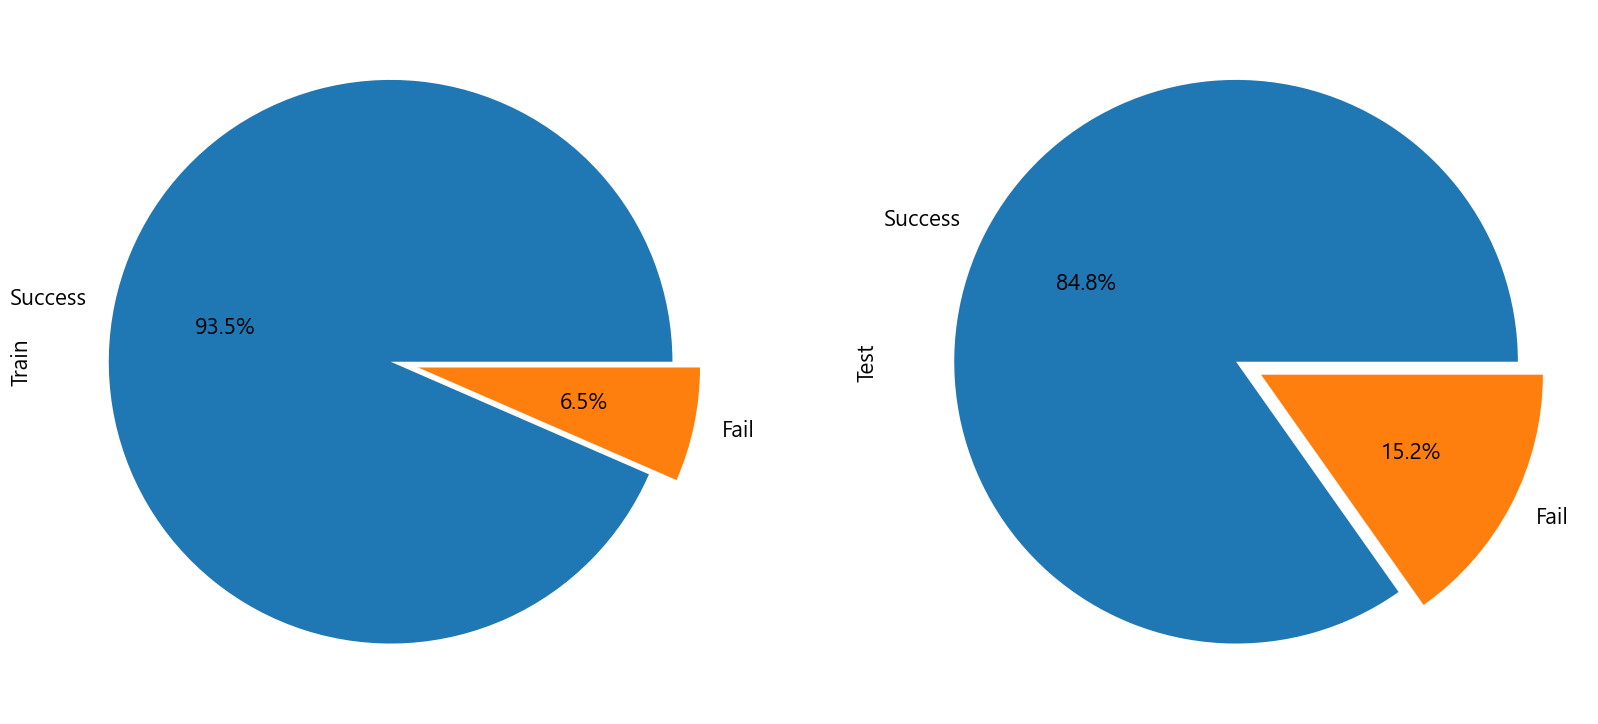

In [55]:
figure, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

result_df['Train'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax1)
result_df['Test'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax2)

plt.show()
plt.close()